# Section 3: Working with Dask DataFrames

# Inspecting a large DataFrame
A Dask DataFrame is provided for you called df. This DataFrame connects to the World Development Indicators data set you worked with earlier.

Your job is to inspect this Dask DataFrame using methods and correctly identify the number of columns, the number of rows, and the number of unique countries from either the Country Name or Country Code columns. You can use methods you are already familiar with such as .describe() and .info(). Remember to also use .compute(), since df is a Dask (and not pandas) DataFrame.

n_columns = 7; n_rows = 123156; n_countries = 217

# Building a pipeline of delayed tasks
For this exercise, you'll use a Dask DataFrame to read and process the World Bank's World Development Indicators.

Your job is to filter the DataFrame for the 'East Asia & Pacific' region and measurements of the percent population exposed to toxic air pollution. The output of this effort is a delayed Dask DataFrame; you'll compute the result in the next exercise.

The CSV file 'WDI.csv' has been truncated to reduce execution time.

In [ ]:
import dask.dataframe as dd 

# Read from 'WDI.csv': df
df = dd.read_csv('../datasets/WDI/WDI.csv')

# Boolean series where 'Indicator Code' is 'EN.ATM.PM25.MC.ZS': toxins
toxins = df['Indicator Code'] == 'EN.ATM.PM25.MC.ZS'
# Boolean series where 'Region' is 'East Asia & Pacific': region
region = df['Region'] == 'East Asia & Pacific'

# Filter the DataFrame using toxins & region: filtered
filtered = df.loc[toxins & region]

In [ ]:
filtered 

# Grouping & aggregating by year
The filtered Dask DataFrame from the previous exercise has been provided for you as filtered. In this exercise you're going to plot the average percent of the population exposed to air pollution in the East Asia & Pacific region from 2010 to 2015.

Your job is to use .groupby() to collect all of the individual country values by the 'Year' column and aggregate with the mean() function. You'll then call .compute() to perform the computation in parallel, and finally plot the results.

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Grouby filtered by the 'Year' column: yearly
yearly = filtered.groupby('Year')

# Calculate the mean of yearly: yearly_mean
yearly_mean = yearly.mean()

# Call .compute() to perform the computation: result
result = yearly_mean.compute()


# Plot the 'value' column with .plot.line()
result['value'].plot.line()
plt.ylabel('% pop exposed')
plt.show()

# Preparing the pipeline
Since pandas and Dask share the same API, we can write functions that work for both libraries. Your job here is to write a function that takes a DataFrame as input, performs Boolean filtering, groupby, and returns the result.

In the next exercise you'll apply this function on Dask and pandas DataFrames and compare the time it takes to complete.

In [6]:
# Define a function with df as input: by_region
def by_region(df):

    # Create the toxins array
    toxins = df['Indicator Code'] == 'EN.ATM.PM25.MC.ZS'

    # Create the y2015 array
    y2015 = df['Year'] == 2015

    # Filter the DataFrame and group by the 'Region' column
    regions = df[toxins & y2015].groupby('Region')

    # Return the mean of the 'value' column of regions
    return regions['value'].mean()

# Comparing Dask & pandas execution times
The function you created in the last exercise can be used with either Dask or Pandas DataFrames. The only difference is that after the function is run on a Dask DataFrame, .compute() must be called on the result to perform the computation.

Your job is to run the by_region function separately on a Pandas DataFrame and a Dask DataFrame read from the same CSV file. To help understand how much time is taken when reading the file you'll compare the execution of the function with the Dask DataFrame to the Pandas DataFrame where the time taken to call pd.read_csv is included or ignored.

In [8]:
import pandas as pd
import time

# Call time.time()
t0 = time.time()

# Read 'WDI.csv' into df
df = pd.read_csv('../datasets/WDI/WDI.csv')

# Group df by region: result
result = by_region(df)

# Call time.time()
t1 = time.time()

# Print the execution time
print((t1-t0)*1000)

112.99896240234375


In [9]:
# Time the execution of just by_region with Pandas and print in milliseconds
df = pd.read_csv('../datasets/WDI/WDI.csv')
t0 = time.time()
result = by_region(df)
t1 = time.time()
print((t1-t0)*1000)

6.002187728881836


In [10]:
# Time the execution of dd.read_csv and by_region together with 'WDI.csv' and print in milliseconds
t0 = time.time()
df = dd.read_csv('../datasets/WDI/WDI.csv')
result = by_region(df)
t1 = time.time()
print((t1-t0)*1000)

31.545639038085938


# Reading & cleaning files
Here you'll be working with a subset of the NYC Taxi Trip data. The first step is to use the Dask dd.read_csv() function to read multiple files at once. Dask will automatically concatenate the contents of the files into a single DataFrame. Notice that you'll use the option assume_missing=True in the call to dd.read_csv() to suppress warning messages.

Your job is to use a glob pattern containing the * character to read all of the CSV files from the taxi/ subdirectory into a single Dask DataFrame. You'll then construct a new column called 'tip_fraction' using the 'tip_amount' and 'total_amount' columns. The 'total_amount' is the sum of the fare, other fees, and the tip_amount.

In [12]:
# Read all .csv files: df
df = dd.read_csv('../datasets/nyctaxi/nyctaxi/*.csv', assume_missing=True)

# Make column 'tip_fraction'
df['tip_fraction'] = df['tip_amount'] / (df['total_amount'] - df['tip_amount'])

# Convert 'tpep_dropoff_datetime' column to datetime objects
df['tpep_dropoff_datetime'] = dd.to_datetime(df['tpep_dropoff_datetime'])

# Construct column 'hour'
df['hour'] = df['tpep_dropoff_datetime'].dt.hour

# Filtering & grouping data
You have the Dask dataframe df prepared using multiple CSV files from the last exercise. It contains a subset of the 2015 yellow taxi ride data from New York City with some additional columns from preprocessing. Remember, none of the files have actually been loaded, nor has any computation been done to construct the new columns.

Your task now is to build a pipeline of computations to compute the hourly average tip fraction for each hour of the day across the entire year of data. You'll have to filter for payments of type 1 (credit card transactions) from the 'payment_type' column, group transactions using the 'hour' column, and finally aggregate the mean from the 'tip_fraction' column.

In [14]:
# Filter rows where payment_type == 1: credit
credit = df.loc[df['payment_type'] == 1]

# Group by 'hour' column: hourly
hourly = credit.groupby('hour')

# Aggregate mean 'tip_fraction' and print its data type
result = hourly['tip_fraction'].mean()
print(type(result))

<class 'dask.dataframe.core.Series'>


# Computing & plotting
Now that you've got the entire delayed pipeline prepared it's time compute and plot the result. Matplotlib has been imported for you as plt.

Warning: The execution of of this exercise is expected to be several seconds.

<class 'pandas.core.series.Series'>


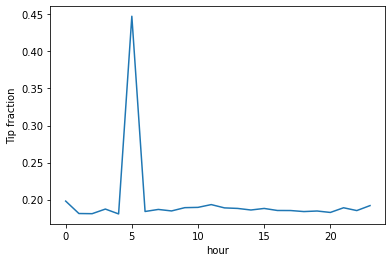

In [15]:
# Perform the computation
tip_frac = result.compute()

# Print the type of tip_frac
print(type(tip_frac))

# Generate a line plot using .plot.line()
tip_frac.plot.line()
plt.ylabel('Tip fraction')
plt.show()